In [1]:
!pip install seaborn
!pip install lazypredict
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 71.6 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # General visualisations
import matplotlib.ticker as mtick # Axis visuals
import seaborn as sns # Statistical visualisations
from math import pi # Radar chart support
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf

# roc_auc_score
plt.style.use('ggplot')

In [3]:
def custom_describe(data):
    # Basic statistics
    desc_stats = data.describe()

    # Missing values count
    missing_values = data.isnull().sum()

    # Unique values count
    unique_values = data.nunique()

    # Identify numeric columns
    numeric_cols = data.select_dtypes(include=['number']).columns

    # Calculate IQR and identify outliers for each numeric column
    outliers = {}
    for col in numeric_cols:
        q1 = desc_stats.loc['25%', col]
        q3 = desc_stats.loc['75%', col]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers[col] = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()

    # Get data types for each column
    data_types = data.dtypes
    
    # Combine all information
    custom_description = pd.DataFrame({
        'data_type': data_types,
        'mean': desc_stats.loc['mean'],
        'std': desc_stats.loc['std'],
        'missing_values': missing_values,
        'unique_values': unique_values,
        'outliers': outliers
    })

    return custom_description

# EDA

In [4]:
df = pd.read_csv("/kaggle/input/earthquake-magnitude-damage-and-impact/csv_building_structure.csv",
                     index_col = 'building_id')

In [5]:
print(df.shape)
df.head()

(762106, 30)


district_id  vdcmun_id  ward_id  count_floors_pre_eq  \
building_id                                                          
120101000011           12       1207   120703                    1   
120101000021           12       1207   120703                    1   
120101000031           12       1207   120703                    1   
120101000041           12       1207   120703                    1   
120101000051           12       1207   120703                    1   

              count_floors_post_eq  age_building  plinth_area_sq_ft  \
building_id                                                           
120101000011                     1             9                288   
120101000021                     1            15                364   
120101000031                     1            20                384   
120101000041                     1            20                312   
120101000051                     1            30                308   

              height_ft_pre_eq  height_ft_post_eq land_surface_condition  ...  \
building_id                                                               ...   
120101000011                 9                  9                   Flat  ...   
120101000021                 9                  9                   Flat  ...   
120101000031                 9                  9                   Flat  ...   
120101000041                 9                  9                   Flat  ...   
120101000051                 9                  9                   Flat  ...   

             has_superstructure_mud_mortar_brick  \
building_id                                        
120101000011                                   0   
120101000021                                   0   
120101000031                                   0   
120101000041                                   0   
120101000051                                   0   

             has_superstructure_cement_mortar_brick has_superstructure_timber  \
building_id                                                                     
120101000011                                      0                         0   
120101000021                                      0                         0   
120101000031                                      0                         0   
120101000041                                      0                         0   
120101000051                                      0                         0   

             has_superstructure_bamboo has_superstructure_rc_non_engineered  \
building_id                                                                   
120101000011                         1                                    0   
120101000021                         1                                    0   
120101000031                         0                                    0   
120101000041                         0                                    0   
120101000051                         0                                    0   

             has_superstructure_rc_engineered  has_superstructure_other  \
building_id                                                               
120101000011                                0                         0   
120101000021                                0                         0   
120101000031                                0                         0   
120101000041                                0                         0   
120101000051                                0                         0   

                      condition_post_eq  damage_grade  \
building_id                                             
120101000011       Damaged-Used in risk       Grade 3   
120101000021  Damaged-Repaired and used       Grade 5   
120101000031  Damaged-Repaired and used       Grade 2   
120101000041  Damaged-Repaired and used       Grade 2   
120101000051  Damaged-Repaired and used       Grade 1   

              technical_solution_proposed  


In [6]:
result = custom_describe(df)
result

data_type           mean           std  \
age_building                               int64      24.326405     65.043704   
condition_post_eq                         object            NaN           NaN   
count_floors_post_eq                       int64       1.252058      1.063275   
count_floors_pre_eq                        int64       2.087783      0.655101   
damage_grade                              object            NaN           NaN   
district_id                                int64      25.767835      5.807555   
foundation_type                           object            NaN           NaN   
ground_floor_type                         object            NaN           NaN   
has_superstructure_adobe_mud               int64       0.042401      0.201502   
has_superstructure_bamboo                  int64       0.080482      0.272039   
has_superstructure_cement_mortar_brick     int64       0.071525      0.257701   
has_superstructure_cement_mortar_stone     int64       0.015815      0.124761   
has_superstructure_mud_mortar_brick        int64       0.022961      0.149780   
has_superstructure_mud_mortar_stone        int64       0.800271      0.399797   
has_superstructure_other                   int64       0.012026      0.109001   
has_superstructure_rc_engineered           int64       0.016386      0.126955   
has_superstructure_rc_non_engineered       int64       0.039794      0.195474   
has_superstructure_stone_flag              int64       0.035121      0.184086   
has_superstructure_timber                  int64       0.258766      0.437957   
height_ft_post_eq                          int64       9.868817      8.574169   
height_ft_pre_eq                           int64      16.049372      5.493878   
land_surface_condition                    object            NaN           NaN   
other_floor_type                          object            NaN           NaN   
plan_configuration                        object            NaN           NaN   
plinth_area_sq_ft                          int64     406.672576    226.779371   
position                                  object            NaN           NaN   
roof_type                                 object            NaN           NaN   
technical_solution_proposed               object            NaN           NaN   
vdcmun_id                                  int64    2582.688357    581.172767   
ward_id                                    int64  258274.277335  58117.348412   

                                        missing_values  unique_values  \
age_building                                         0            176   
condition_post_eq                                    0              8   
count_floors_post_eq                                 0             10   
count_floors_pre_eq                                  0              9   
damage_grade                                        12              5   
district_id                                          0             11   
foundation_type                                      0              5   
ground_floor_type                                    0              5   
has_superstructure_adobe_mud                         0              2   
has_superstructure_bamboo                            0              2   
has_superstructure_cement_mortar_brick               0              2   
has_superstructure_cement_mortar_stone               0              2   
has_superstructure_mud_mortar_brick                  0              2   
has_superstructure_mud_mortar_stone                  0              2   
has_superstructure_other                             0              2   
has_superstructure_rc_engineered                     0              2   
has_superstructure_rc_non_engineered                 0              2   
has_superstructure_stone_flag                        0              2   
has_superstructure_timber                            0              2   
height_ft_post_eq                                    0             

In [7]:
# Convert data types to categorical
df = df.astype({
    'district_id': 'object', 
    'vdcmun_id': 'object', 
    'ward_id': 'object',
    'has_superstructure_adobe_mud': 'object',
    'has_superstructure_bamboo': 'object',
    'has_superstructure_cement_mortar_brick': 'object',
    'has_superstructure_cement_mortar_stone': 'object',
    'has_superstructure_mud_mortar_brick': 'object',
    'has_superstructure_mud_mortar_stone': 'object',
    'has_superstructure_other': 'object',
    'has_superstructure_rc_engineered': 'object',
    'has_superstructure_rc_non_engineered': 'object',
    'has_superstructure_timber': 'object',
    'has_superstructure_stone_flag': 'object'
})

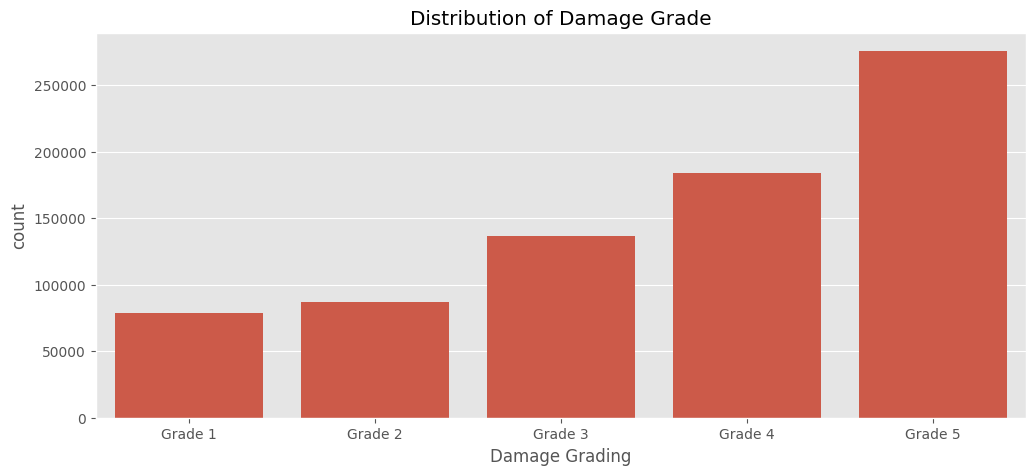

In [8]:
# Exploratory Analysis

plt.figure(figsize=(12,5))
ax = sns.countplot(x='damage_grade', data=df, order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])
plt.title("Distribution of Damage Grade")
plt.xlabel("Damage Grading")
plt.show()

In [9]:
df.groupby(['district_id','damage_grade']).size().reset_index(name='count').set_index(['district_id', 'damage_grade'])

count
district_id damage_grade       
12          Grade 1        7961
            Grade 2        8605
            Grade 3        9220
            Grade 4        7946
            Grade 5        5620
20          Grade 1       13087
            Grade 2       14469
            Grade 3       17085
            Grade 4       15917
            Grade 5        8191
21          Grade 1        2116
            Grade 2        7151
            Grade 3       16945
            Grade 4       20910
            Grade 5       11490
22          Grade 1        1353
            Grade 2        2993
            Grade 3        6520
            Grade 4       14409
            Grade 5       35364
23          Grade 1        1233
            Grade 2        2009
            Grade 3        3271
            Grade 4       10796
            Grade 5       71432
24          Grade 1        8330
            Grade 2       11726
            Grade 3       25130
            Grade 4       28974
            Grade 5       23859
28          Grade 1        2615
            Grade 2        2745
            Grade 3        8209
            Grade 4       23284
            Grade 5       40295
29          Grade 1         277
            Grade 2         343
            Grade 3         782
            Grade 4        2064
            Grade 5        9178
30          Grade 1        4952
            Grade 2        7526
            Grade 3       15218
            Grade 4       26080
            Grade 5       35346
31          Grade 1       32540
            Grade 2       21135
            Grade 3       18525
            Grade 4       10928
            Grade 5        7866
36          Grade 1        4351
            Grade 2        8555
            Grade 3       15507
            Grade 4       22536
            Grade 5       27125

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


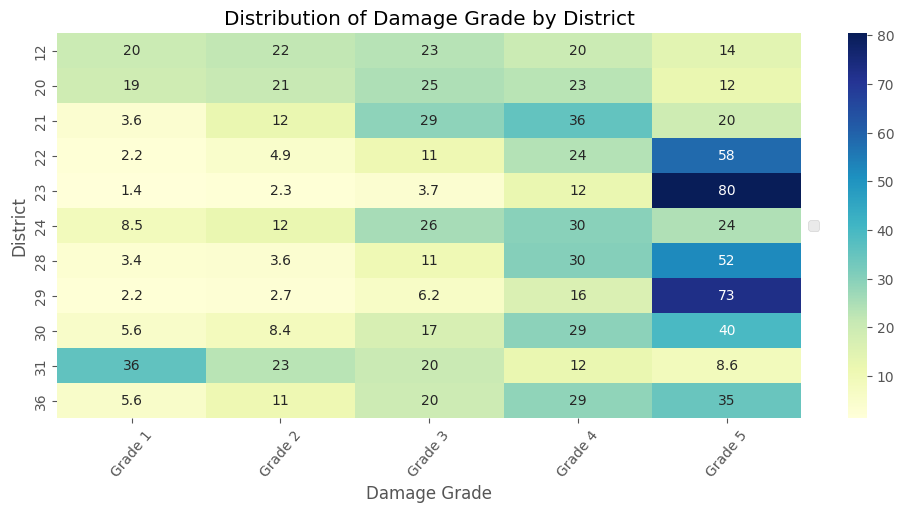

In [10]:
# Calculate counts
df_temp = df.groupby(['district_id', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('district_id')['count'].transform(lambda x: 100 * x / x.sum())

# Pivot table
df_temp = df_temp.pivot_table(values='proportion', index='district_id', columns='damage_grade')

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.heatmap(data=df_temp, annot=True, cmap="YlGnBu")
plt.xticks(rotation=50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by District")
plt.xlabel("Damage Grade")
plt.ylabel("District")
plt.show()

# Clean up
del df_temp, ax

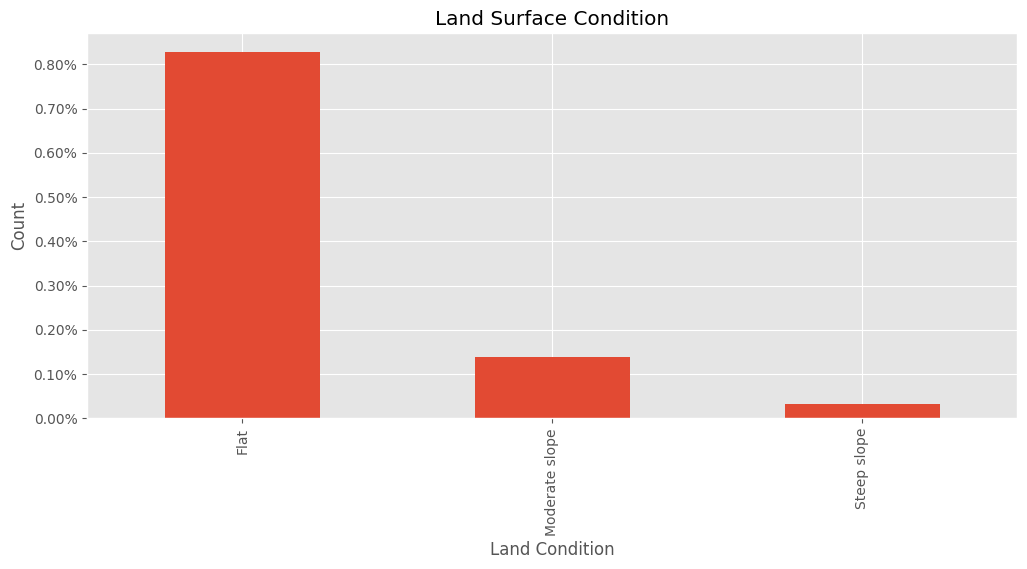

In [11]:
# Create a plot
plt.figure(figsize=(12,5))
ax = df.land_surface_condition.value_counts(normalize = True).plot(kind = "bar")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Land Surface Condition")
plt.ylabel("Count")
plt.xlabel("Land Condition")
plt.show()

# clean script
del ax

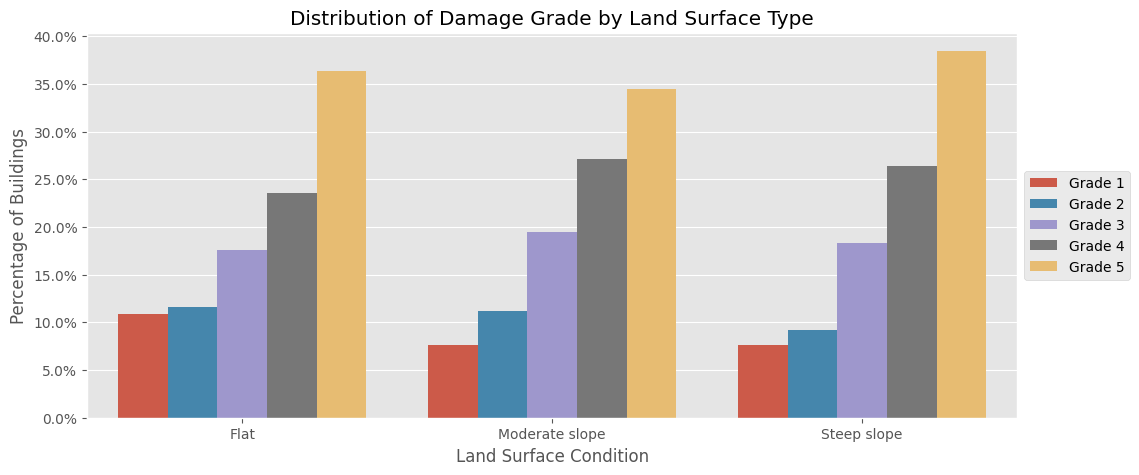

In [12]:
# Calculate counts
df_temp = df.groupby(['land_surface_condition', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('land_surface_condition')['count'].transform(lambda x: 100 * x / x.sum())

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=df_temp, 
                 x='land_surface_condition', 
                 y='proportion', 
                 hue='damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Land Surface Type")
plt.xlabel("Land Surface Condition")
plt.ylabel("Percentage of Buildings")
plt.show()

# Clean up
del df_temp, ax

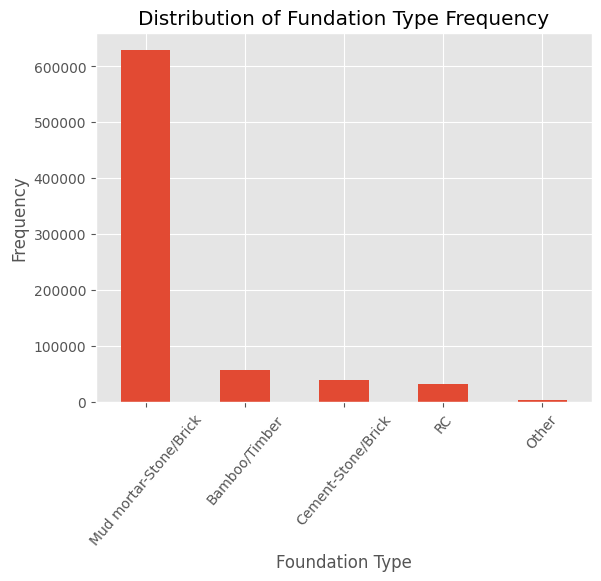

In [13]:
df.foundation_type.value_counts().plot(kind="bar")
plt.xticks(rotation=50)
plt.title("Distribution of Fundation Type Frequency")
plt.xlabel("Foundation Type")
plt.ylabel("Frequency")
plt.show()

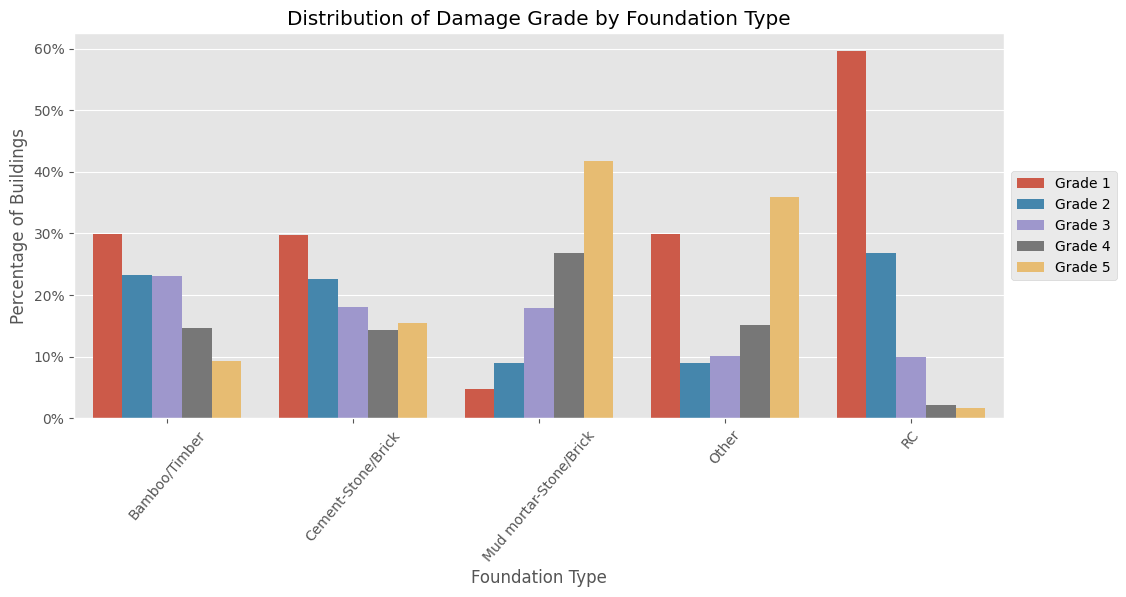

In [14]:
# Calculate counts
df_temp = df.groupby(['foundation_type', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('foundation_type')['count'].transform(lambda x: 100 * x / x.sum())

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=df_temp, 
                 x='foundation_type', 
                 y='proportion', 
                 hue='damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Foundation Type")
plt.ylabel("Percentage of Buildings")
plt.show()

# Clean up
del df_temp, ax

In [15]:
# Calculate counts
df_temp = df.groupby(['foundation_type', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('foundation_type')['count'].transform(lambda x: 100 * x / x.sum())

# Pivot table
df_temp = pd.pivot_table(df_temp, values='proportion', index=['foundation_type'], columns='damage_grade')

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.heatmap(data=df_temp, annot=True, cmap="YlGnBu")
plt.xticks(rotation=50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Damage Grade")
plt.ylabel("Foundation Type")
plt.show()

# Clean up
del df_temp, ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [16]:
df.foundation_type.value_counts().plot(kind="bar");

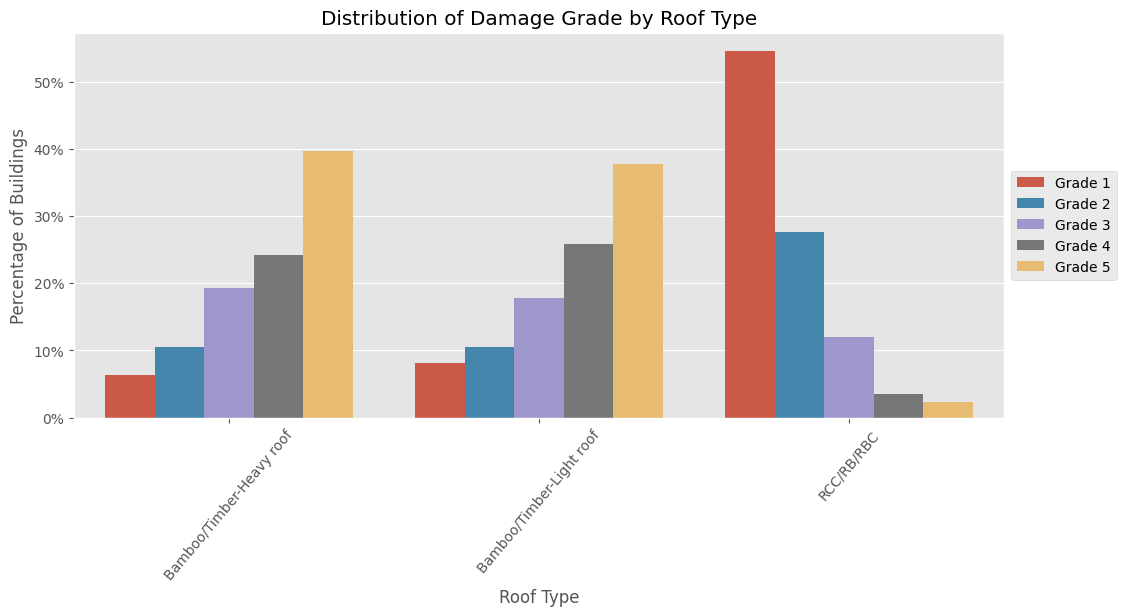

In [17]:
# Calculate counts
df_temp = df.groupby(['roof_type', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('roof_type')['count'].transform(lambda x: 100 * x / x.sum())

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=df_temp, 
                 x='roof_type', 
                 y='proportion', 
                 hue='damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Roof Type")
plt.xlabel("Roof Type")
plt.ylabel("Percentage of Buildings")
plt.show()

# Clean up
del df_temp, ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


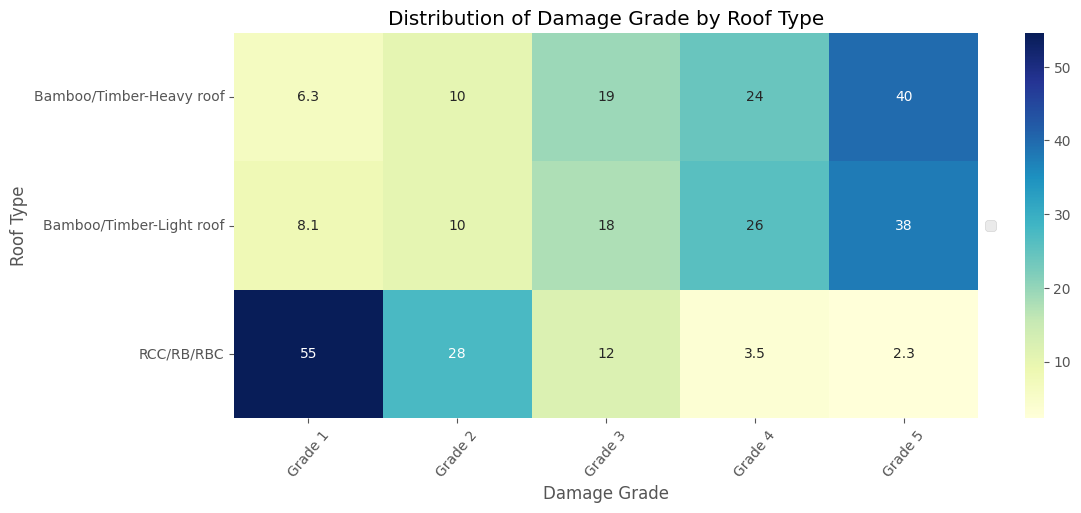

In [18]:
# Calculate counts
df_temp = df.groupby(['roof_type', 'damage_grade']).size().reset_index(name='count')

# Calculate Proportion of grade
df_temp['proportion'] = df_temp.groupby('roof_type')['count'].transform(lambda x: 100 * x / x.sum())

# Pivot table
df_temp = pd.pivot_table(df_temp, values='proportion', index=['roof_type'], columns='damage_grade')

# Plot chart
plt.figure(figsize=(12, 5))
ax = sns.heatmap(data=df_temp, annot=True, cmap="YlGnBu")
plt.xticks(rotation=50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Roof Type")
plt.xlabel("Damage Grade")
plt.ylabel("Roof Type")
plt.show()

# Clean up
del df_temp, ax

# Cleanse

In [8]:
# Drop Nulls
df.dropna(inplace=True)

In [9]:
# Checking for high cardinality columns
df.select_dtypes("object").nunique()

district_id                                11
vdcmun_id                                 110
ward_id                                   945
land_surface_condition                      3
foundation_type                             5
roof_type                                   3
ground_floor_type                           5
other_floor_type                            4
position                                    4
plan_configuration                         10
has_superstructure_adobe_mud                2
has_superstructure_mud_mortar_stone         2
has_superstructure_stone_flag               2
has_superstructure_cement_mortar_stone      2
has_superstructure_mud_mortar_brick         2
has_superstructure_cement_mortar_brick      2
has_superstructure_timber                   2
has_superstructure_bamboo                   2
has_superstructure_rc_non_engineered        2
has_superstructure_rc_engineered            2
has_superstructure_other                    2
condition_post_eq                 

In [10]:
cols_to_drop = ["vdcmun_id", "ward_id"]

In [11]:
# Drop leaky columns, no predictive power!
cols_to_drop+=[col for col in df.columns if "post_eq" in col]
cols_to_drop.append("technical_solution_proposed")

In [12]:
df["plan_configuration"].value_counts()

plan_configuration
Rectangular                        731246
Square                              17576
L-shape                             10079
T-shape                               969
Multi-projected                       940
Others                                518
U-shape                               448
E-shape                               140
Building with Central Courtyard        98
H-shape                                80
Name: count, dtype: int64

In [13]:
cols_to_drop.append("plan_configuration")

In [14]:
# Deciding the target to be (severe=1,not_severe=0)
df["damage_grade"]=df["damage_grade"].str[-1].astype(int)
df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
cols_to_drop.append("damage_grade")

In [15]:
df.drop(columns=cols_to_drop, inplace=True)

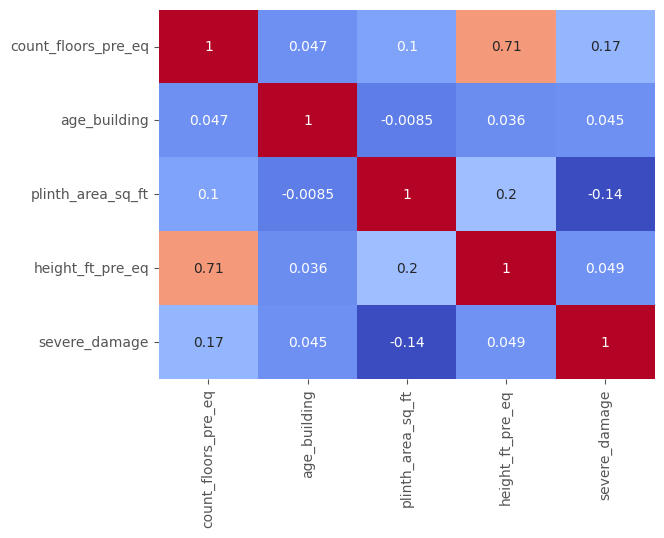

In [16]:
sns.heatmap(df.select_dtypes("number").corr(), cmap='coolwarm', annot=True, cbar=False)
plt.show()

In [17]:
# Drop multi linearity column
df.drop(columns="height_ft_pre_eq", inplace=True)

## Outliers

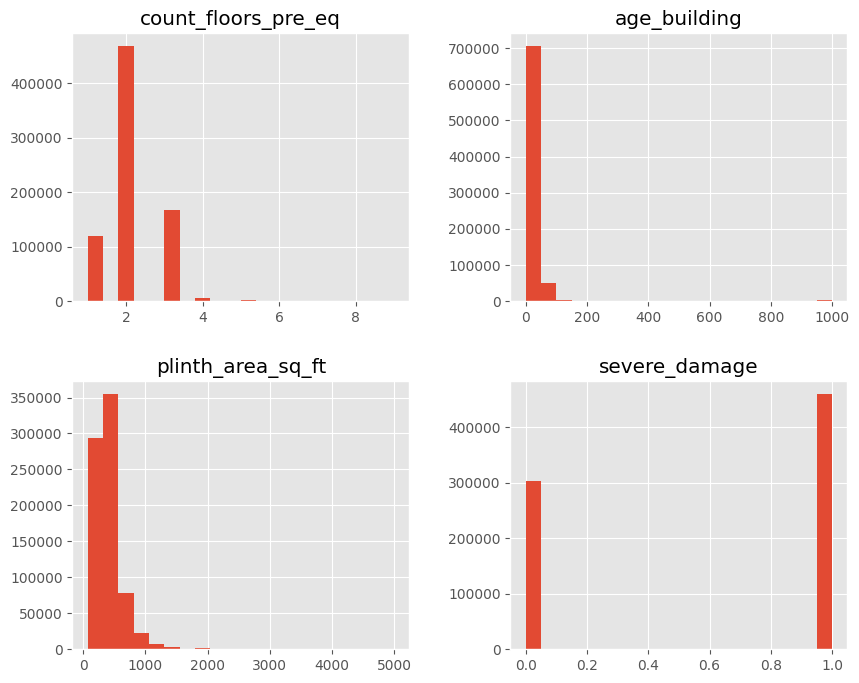

In [18]:
df.hist(figsize=(10, 8), bins=20);

In [19]:
df.plot(kind="box", figsize=(10, 8));

In [20]:
def find_outliers_IQR(df):
    q1=df.quantile(0.15)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

In [21]:
# Seeing how many outliers

index = find_outliers_IQR(df["age_building"]).index
print(f"percentage of outliers [age_building] = {round(len(index)/df.shape[0],2)}%") 

df.drop(index, axis=0, inplace=True)


index = find_outliers_IQR(df["plinth_area_sq_ft"]).index
print(f"percentage of outliers [plinth_area_sq_ft] = {round(len(index)/df.shape[0],2)}%") 

df.drop(index, axis=0, inplace=True)

percentage of outliers [age_building] = 0.03%
percentage of outliers [plinth_area_sq_ft] = 0.05%


In [22]:
df.hist(figsize=(10, 8), bins=20);

In [23]:
df.plot(kind="box", figsize=(10, 8));

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 702585 entries, 120101000011 to 366709001271
Data columns (total 22 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   district_id                             702585 non-null  object
 1   count_floors_pre_eq                     702585 non-null  int64 
 2   age_building                            702585 non-null  int64 
 3   plinth_area_sq_ft                       702585 non-null  int64 
 4   land_surface_condition                  702585 non-null  object
 5   foundation_type                         702585 non-null  object
 6   roof_type                               702585 non-null  object
 7   ground_floor_type                       702585 non-null  object
 8   other_floor_type                        702585 non-null  object
 9   position                                702585 non-null  object
 10  has_superstructure_adobe_mud            7025

In [25]:
df["district_id"].value_counts()

district_id
24    87637
30    83684
23    81897
31    79082
36    72389
28    71584
20    65337
22    57165
21    55278
12    37145
29    11387
Name: count, dtype: int64

In [33]:
df24 = df.copy()

## Split

In [34]:
X = df24.drop('severe_damage', axis = 1)
y = df24['severe_damage']

In [35]:
#  Cre1ate training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = df24['severe_damage'],
                                                    shuffle=True)

# Calculate proportions on train and test
train_proportions = y_train.value_counts(normalize=True).reset_index(name="train")
test_proportions = y_test.value_counts(normalize=True).reset_index(name="test")

# Merge on the 'damage_grade' column
merged_proportions = pd.merge(train_proportions, test_proportions, on="severe_damage", how="left")

merged_proportions

severe_damage     train      test
0              1  0.612517  0.612517
1              0  0.387483  0.387483

In [36]:
# Print x train shape before processing
print("Before preprocessing there were {} rows and {} columns".format(*X_train.shape))

# Identify columns
fts_cat = X.select_dtypes('object').columns
fts_num = X.select_dtypes("number").columns

# Create a single Preprocessing step for predictors
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), fts_num), # Centre and scale
        ('ohe', OneHotEncoder(handle_unknown='ignore'), fts_cat), # One Hot encode
    ])
      
# Apply the transformations to both train and test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.fit_transform(X_test)   

# Print x train shape before processing
print("After preprocessing there are {} rows and {} columns".format(*X_train_transformed.shape))

Before preprocessing there were 562068 rows and 21 columns
After preprocessing there are 562068 rows and 60 columns


# Modeling

## Model Selection using Lazypredict

In [ ]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_transformed, X_test_transformed, y_train, y_test)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-12-17 01:40:08.826605: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-17 01:40:08.826720: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-17 01:40:08.826804: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-17 01:40:08.826876: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-17 01:40:08.826945: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-17 01:40:08.827189: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-17 01:40:08.827312: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

  3%|▎         | 1/29 [00:42<19:58, 42.82s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.7561718510927503, 'Balanced Accuracy': 0.7251464074022139, 'ROC AUC': 0.7251464074022139, 'F1 Score': 0.7500354960587062, 'Time taken': 42.820411920547485}


  7%|▋         | 2/29 [01:27<19:46, 43.94s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.7362525530718703, 'Balanced Accuracy': 0.7216863234968416, 'ROC AUC': 0.7216863234968416, 'F1 Score': 0.7361199466586357, 'Time taken': 44.72513151168823}


 10%|█         | 3/29 [01:29<10:46, 24.88s/it]

{'Model': 'BernoulliNB', 'Accuracy': 0.7301180640064903, 'Balanced Accuracy': 0.684199321575521, 'ROC AUC': 0.6841993215755209, 'F1 Score': 0.7153791557639617, 'Time taken': 2.185692071914673}


 14%|█▍        | 4/29 [02:01<11:28, 27.53s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.7564209312752194, 'Balanced Accuracy': 0.7237539341269996, 'ROC AUC': 0.7237539341269995, 'F1 Score': 0.7495404934578648, 'Time taken': 31.586171627044678}


 21%|██        | 6/29 [02:10<05:33, 14.50s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7086188859710925, 'Balanced Accuracy': 0.6962071460157094, 'ROC AUC': 0.6962071460157094, 'F1 Score': 0.7094724280535348, 'Time taken': 7.487194299697876}


 24%|██▍       | 7/29 [02:11<03:45, 10.26s/it]

{'Model': 'DummyClassifier', 'Accuracy': 0.6125166349979007, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.4653305522639025, 'Time taken': 1.5252907276153564}


 28%|██▊       | 8/29 [02:14<02:45,  7.88s/it]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.7139136189927198, 'Balanced Accuracy': 0.7014368068153002, 'ROC AUC': 0.7014368068153002, 'F1 Score': 0.7146642828620663, 'Time taken': 2.7784879207611084}


 31%|███       | 9/29 [04:17<14:39, 43.99s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.7294064063422931, 'Balanced Accuracy': 0.7141241220589278, 'ROC AUC': 0.7141241220589278, 'F1 Score': 0.7291727541106949, 'Time taken': 123.37914776802063}


 34%|███▍      | 10/29 [04:20<09:50, 31.09s/it]

{'Model': 'GaussianNB', 'Accuracy': 0.7242895877367151, 'Balanced Accuracy': 0.6704503840461333, 'ROC AUC': 0.6704503840461333, 'F1 Score': 0.7033445163977399, 'Time taken': 2.2014057636260986}


 38%|███▊      | 11/29 [04:35<07:51, 26.19s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.7509127009543329, 'Balanced Accuracy': 0.7300738842700565, 'ROC AUC': 0.7300738842700565, 'F1 Score': 0.7487298971449836, 'Time taken': 15.070727586746216}


In [ ]:
print(models)

## Random Forest

In [50]:
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=263,
        max_depth=31,
        min_samples_split=2,
        min_samples_leaf=4,
        random_state=42
    ))
])

rf.fit(X_train, y_train) # fit model
y_pred = rf.predict(X_test) # predict on test

# Calculate confusion matrix
con_mat = confusion_matrix(y_test, y_pred)
con_mat = con_mat / con_mat.astype(float).sum(axis=1)


print('Test Accuracy of random forest Model: ',round(100*rf.score(X_test, y_test),2),'%')
print('')
print('Train Accuracy of random forest Model: ',round(100*rf.score(X_train, y_train),2),'%')
print('')

# Plot Model
plt.figure(figsize = (12,6))
ax = sns.heatmap(con_mat, annot = True)
plt.title("Confusion Matrix")
plt.show()

Test Accuracy of random forest Model:  77.46 %

Train Accuracy of random forest Model:  79.07 %



In [49]:
import optuna

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 600)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    # Create the Random Forest Classifier with the suggested hyperparameters
    random_forest = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Train the model
    random_forest.fit(X_train_transformed, y_train)

    # Make predictions on the test set
    y_pred = random_forest.predict(X_test_transformed)

    # Calculate accuracy as the objective to optimize
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # You can adjust the number of trials

[I 2023-12-17 02:29:56,416] A new study created in memory with name: no-name-3b7f259a-6b09-4d49-a0c5-d86d152d8733
[I 2023-12-17 02:32:59,994] Trial 0 finished with value: 0.7746891835151619 and parameters: {'n_estimators': 263, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7746891835151619.
[I 2023-12-17 02:34:17,878] Trial 1 finished with value: 0.7405224990570536 and parameters: {'n_estimators': 224, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7746891835151619.
[I 2023-12-17 02:35:36,779] Trial 2 finished with value: 0.7156785299999289 and parameters: {'n_estimators': 557, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7746891835151619.
[I 2023-12-17 02:36:52,635] Trial 3 finished with value: 0.7243678700797769 and parameters: {'n_estimators': 402, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0

KeyboardInterrupt: 

In [ ]:
# Print the best parameters and their corresponding accuracy
print("Best Parameters: ", study.best_params)
print("Best Accuracy: {:.2f}%".format(study.best_value * 100))

## KNN

In [41]:

knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Calculate confusion matrix
con_mat = confusion_matrix(y_test, y_pred)
con_mat = con_mat / con_mat.astype(float).sum(axis=1)


print('Test Accuracy of random forest Model: ',round(100*accuracy_score(y_pred, y_test),2),'%')
print('')
print('Train Accuracy of random forest Model: ',round(100*accuracy_score(knn.predict(X_train), y_train),2),'%')
print('')

# Plot Model
plt.figure(figsize = (12,6))
ax = sns.heatmap(con_mat, annot = True)
plt.title("Confusion Matrix")
plt.show()


Test Accuracy of random forest Model:  75.11 %

Train Accuracy of random forest Model:  82.13 %



In [ ]:

def objective(trial):
    # Define the hyperparameter search space
    n_neighbors = trial.suggest_int('n_neighbors', 1, 12)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

    # Create the KNN classifier with the suggested hyperparameters
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm
    )

    # Train the model
    knn.fit(X_train_transformed, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test_transformed)

    # Calculate accuracy as the objective to optimize
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Create a study object and optimize the objective function
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective, n_trials=10)  # You can adjust the number of trials

[I 2023-12-17 02:55:29,818] A new study created in memory with name: no-name-813cfb7a-b2a9-49d7-bbfa-828709dc90b9


In [ ]:
# Print the best parameters and their corresponding accuracy
print("Best Parameters: ", study.best_params)
print("Best Accuracy: {:.2f}%".format(study.best_value * 100))

## AdaBoost

In [ ]:

ada_boost = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(n_estimators=50, learning_rate=1.0))
])

ada_boost.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ada_boost.predict(X_test)

# Calculate confusion matrix
con_mat = confusion_matrix(y_test, y_pred)
con_mat = con_mat / con_mat.astype(float).sum(axis=1)


print('Test Accuracy of random forest Model: ',round(100*accuracy_score(y_pred, y_test),2),'%')
print('')
print('Train Accuracy of random forest Model: ',round(100*accuracy_score(ada_boost.predict(X_train), y_train),2),'%')
print('')

# Plot Model
plt.figure(figsize = (12,6))
ax = sns.heatmap(con_mat, annot = True)
plt.title("Confusion Matrix")
plt.show()




In [ ]:
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 600)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)

    # Create the AdaBoostClassifier with the suggested hyperparameters
    adaboost = AdaBoostClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    # Train the model
    adaboost.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = adaboost.predict(X_test)

    # Calculate accuracy as the objective to optimize
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Create a study object and optimize the objective function
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective, n_trials=10)  # You can adjust the number of trials